In [3]:
%pip install scikit-image


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/A* Line Segmentation'

/content/drive/MyDrive/Colab Notebooks/A* Line Segmentation


In [5]:
%pip install fitz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00


In [9]:
%pip install tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46729 sha256=e60cad62b61647f635d8c45410d504c2dffb02fd7a1dba7df747d19f622c4251
  Stored in directory: /root/.cache/pip/wheels/bc/d8/9d/52ad6058db295741fe0b776c0fcfdb6670036acab59ce4ccfd
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32876 sha256=6c91f09b6ce2ea8a350a6bd337add264284f1bc078b0a5d97e25cf93de985475
  Stored in directory: /root/.cache/pip/wheels/66/b9/15/482258065bee884b0d43bdc24b424e2cc6bde530e8e1380657
Successfully built tools pytils


In [11]:
%pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 99.8 MB/s eta 0:00:00


In [13]:
import fitz
import pymupdf
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from imageio import imread

# Step 1: Convert the first page of a PDF to a PNG image using fitz
def convert_pdf_to_image(pdf_path, output_folder):
    doc = pymupdf.open(pdf_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    page = doc.load_page(1)  # Load the first page (index 0)
    pix = page.get_pixmap()
    image_path = os.path.join(output_folder, f"{pdf_path[9:20]}_page_1.png")
    pix.save(image_path)
    doc.close()
    return image_path

pdf_path = "Buendia - Instruccion.pdf"
output_folder = "test_output_folder"
image_path = convert_pdf_to_image(pdf_path, output_folder)

1314 x 1669


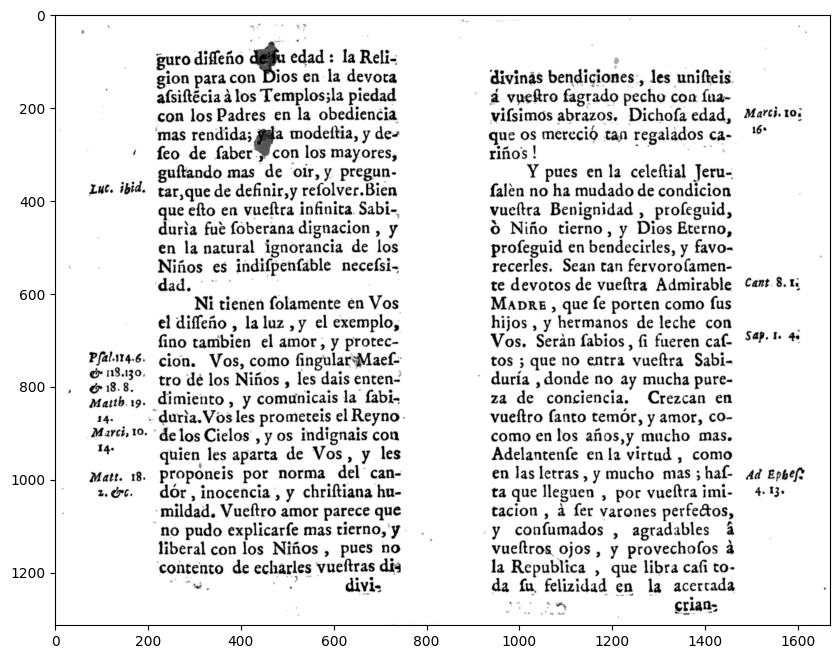

In [3]:
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

img = imread("test_output_folder/ Instruccio_page_1.png")[:,:,:]

# img = resize(img, (511, 366))

print(f'{img.shape[0]} x {img.shape[1]}')

if img.ndim > 2: # is this is a rgb/rgba image
    img = rgb2gray(img)

plt.figure(figsize=(10,10))
# plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview

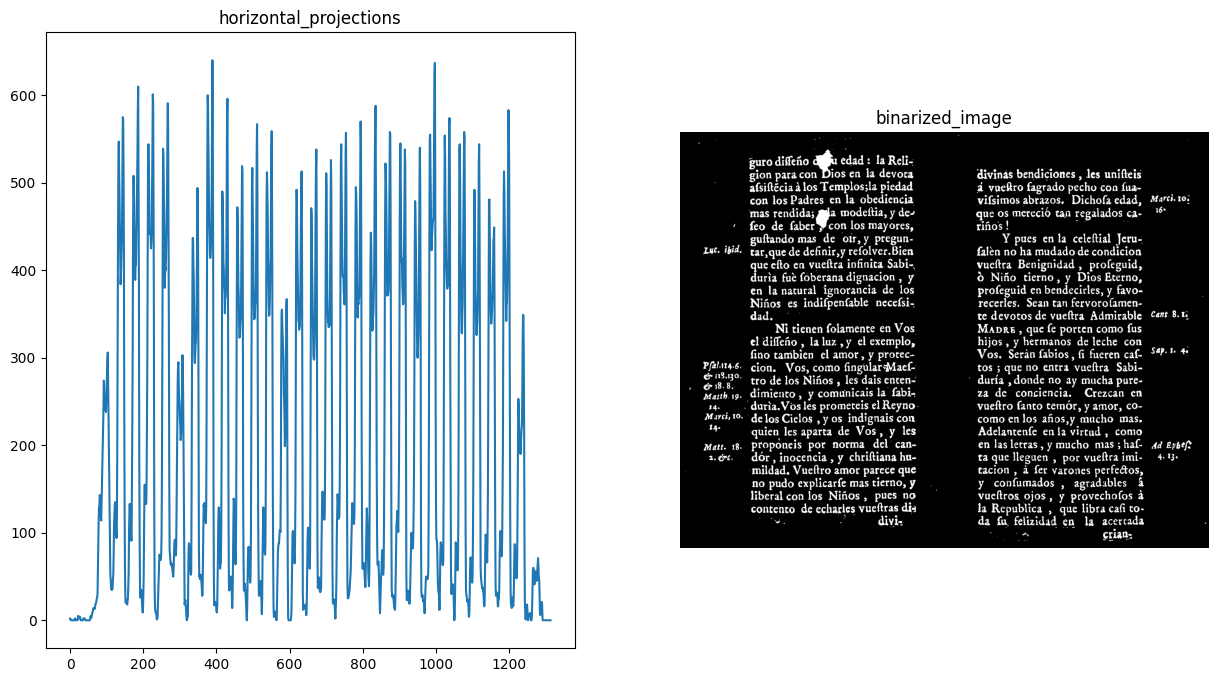

In [4]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold

binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

320.0


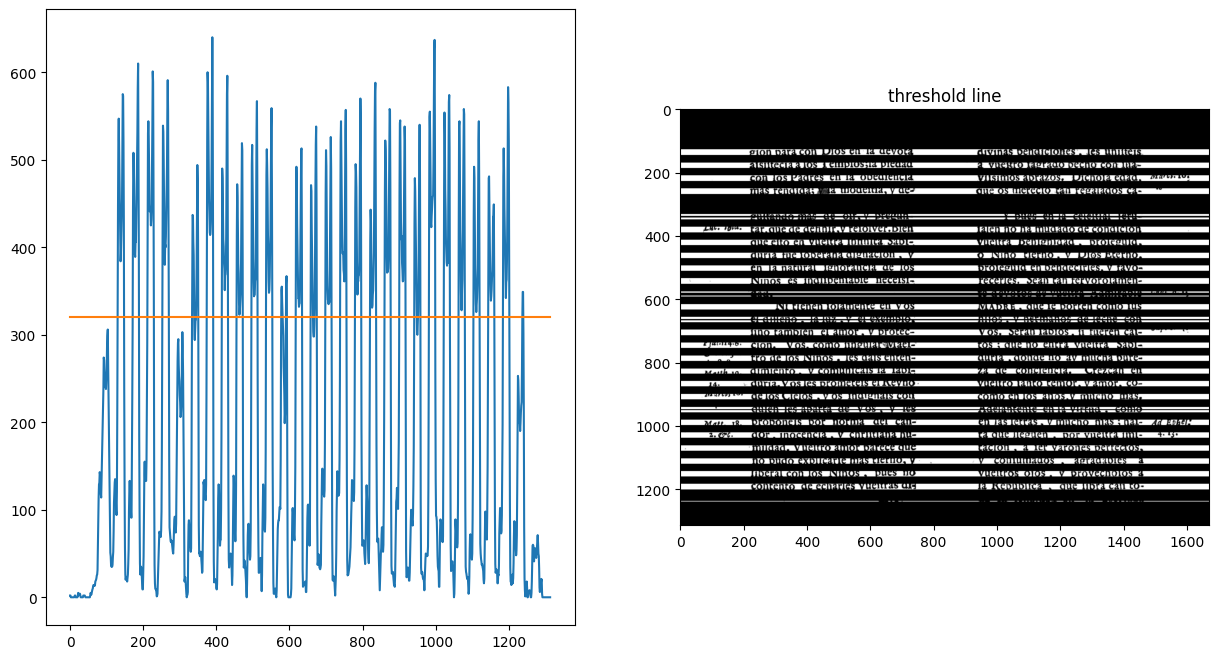

In [31]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research.
# This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
# threshold = 238.9150792382297

print(threshold)
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()

In [7]:
from sklearn.cluster import KMeans

# Reshape the data for clustering
hpp_reshaped = hpp.reshape(-1, 1)

# Apply KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(hpp_reshaped)

# Set the threshold between the two clusters
threshold = np.mean(kmeans.cluster_centers_)
threshold

238.9150792382297

In [29]:
# min_gap = 5  # Adjust this value based on testing
# filtered_peaks = []
# prev_peak = -min_gap  # Initialize to a negative value

# for peak in peaks_indexes:
#     if peak - prev_peak > min_gap:
#         filtered_peaks.append(peak)
#     prev_peak = peak

# peaks_indexes = np.array(filtered_peaks)

In [32]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 28


In [9]:
# A star path planning algorithm
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

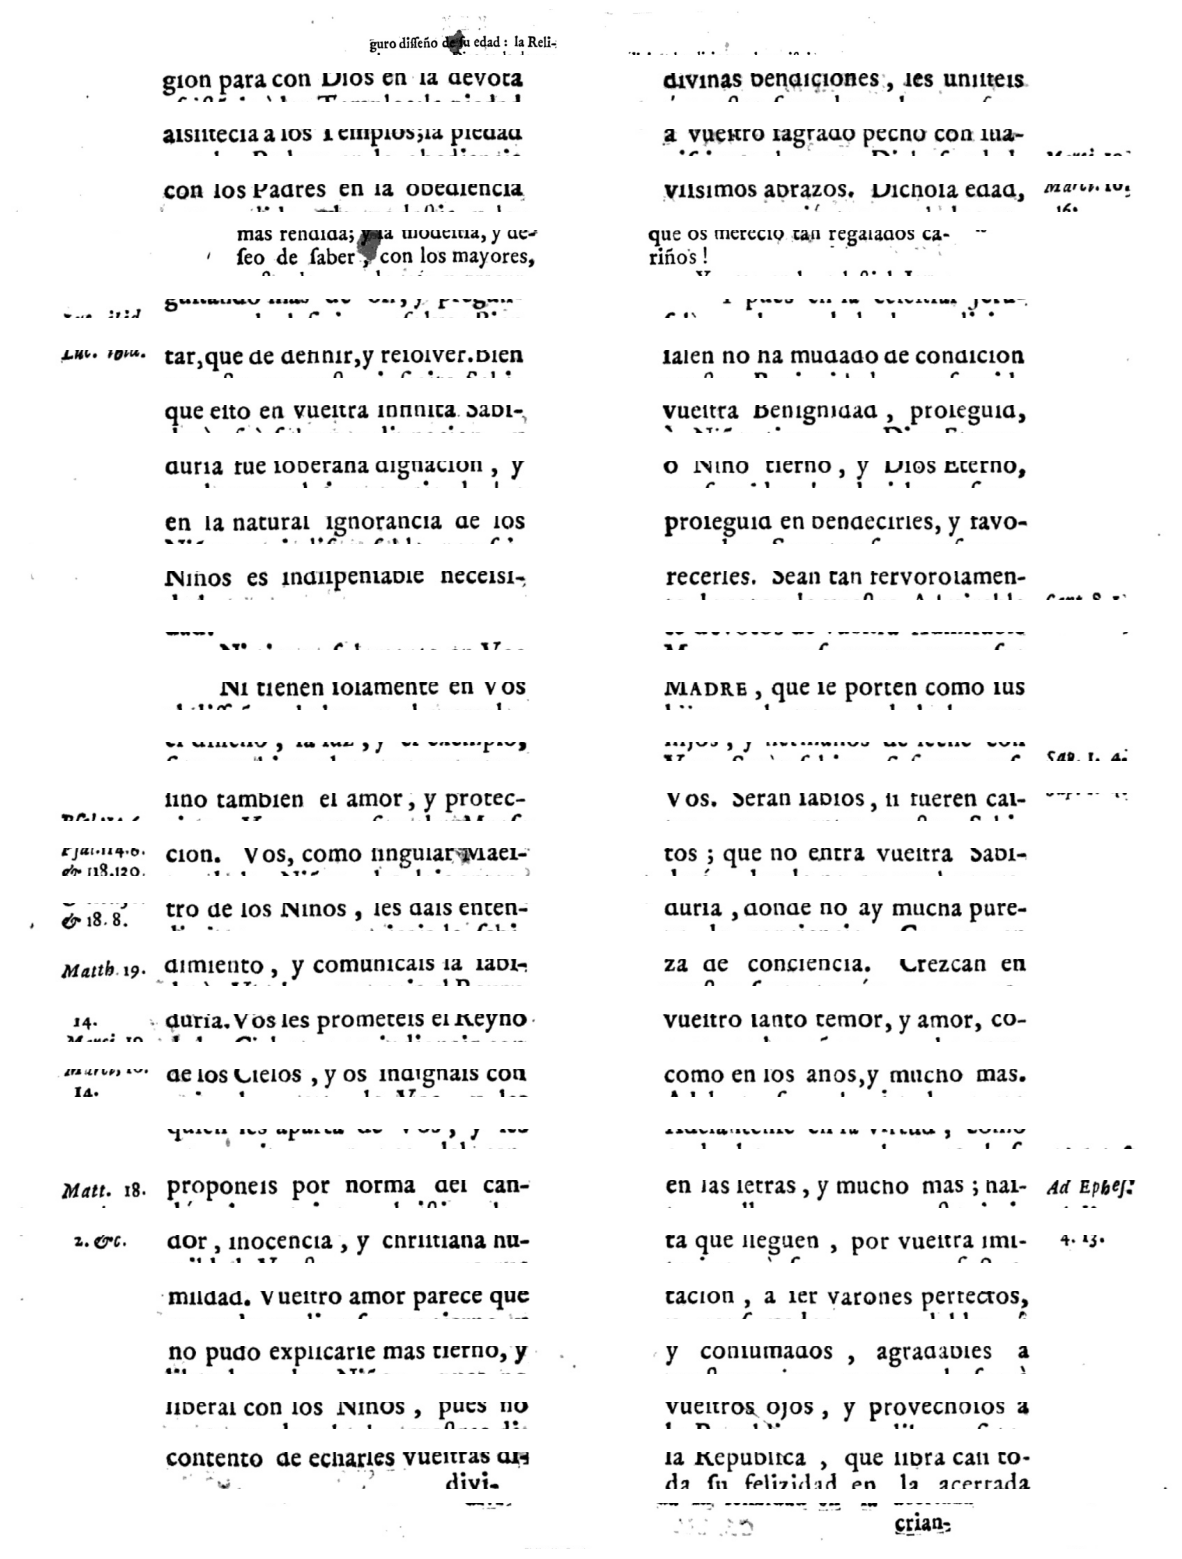

In [33]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [34]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.graph import route_through_array

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary.astype(np.uint8)  # Convert to uint8 for consistency
    return binary

binary_image = get_binary(img)
segment_separating_lines = []

for sub_image_index in peak_groups:
    start_row = sub_image_index[0]
    end_row = sub_image_index[-1]

    # Ensure start_row and end_row are within the bounds of the image
    start_row = max(0, start_row)
    end_row = min(binary_image.shape[0], end_row)

    # Extract the relevant portion of the binary image
    nmap = binary_image[start_row:end_row, :]

    # Define start and end points for A* algorithm
    start_point = (int(nmap.shape[0] / 2), 0)
    end_point = (int(nmap.shape[0] / 2), nmap.shape[1] - 1)

    # Find path using A* algorithm
    path, _ = route_through_array(nmap, start_point, end_point)

    # Add the offset to the path to get coordinates in the original image
    path = np.array(path) + start_row

    # Append the path to the list of segment separating lines
    segment_separating_lines.append(path)

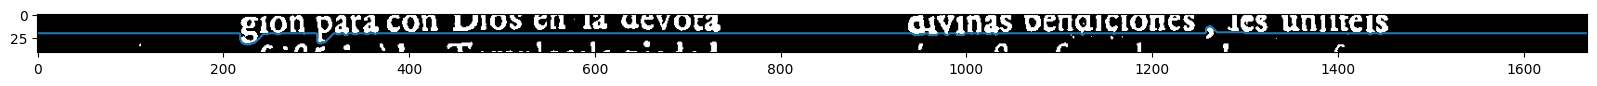

In [35]:
# visualize a sample
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot([x[1] for x in path], [x[0] for x in path])  # Extracting x and y coordinates separately

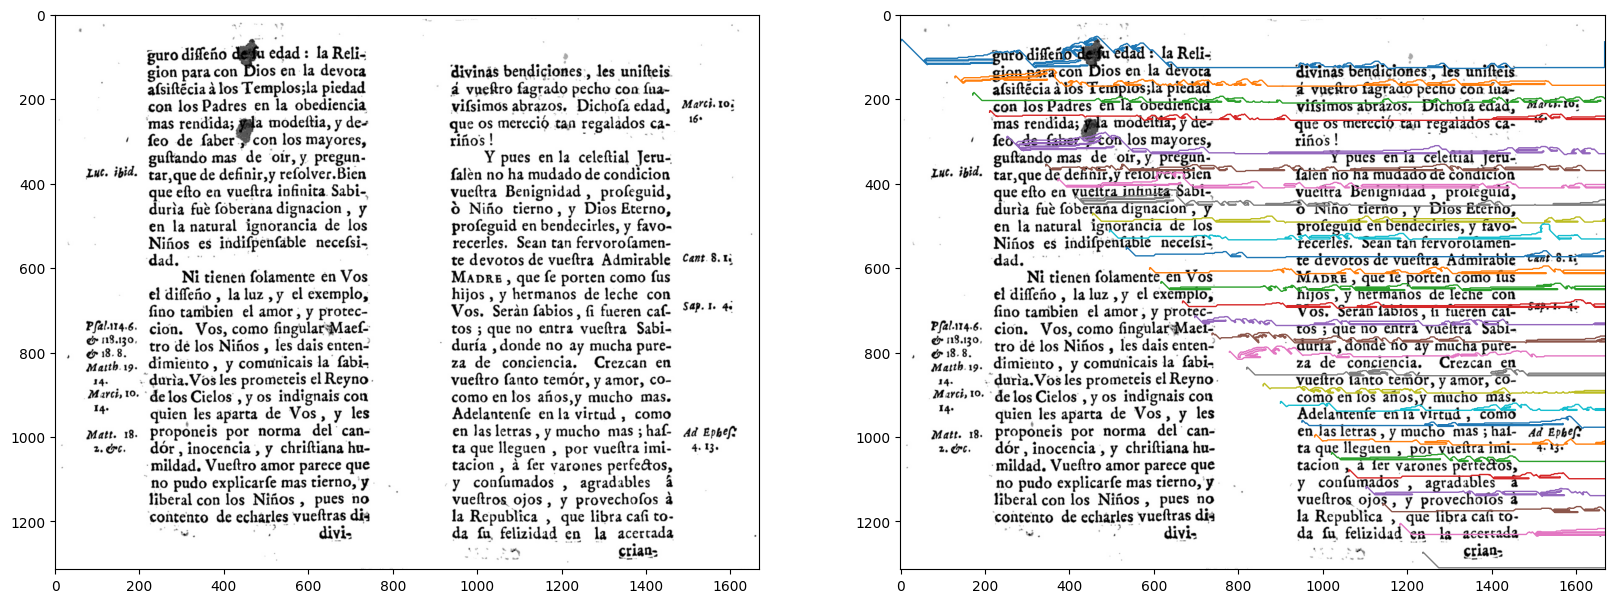

In [36]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0], linewidth=1)
# for start, end in peak_groups:
#     ax[1].axhline(y=start, color='blue', linestyle='--', linewidth=1)  # Dashed blue lines
#     ax[1].axhline(y=end, color='blue', linestyle='--', linewidth=1)
ax[1].imshow(img, cmap="gray")  # 70% opacity
# ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

In [38]:
seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        # lower_line = np.min(segment_separating_lines[index][:,0])            min max
        # upper_line = np.max(segment_separating_lines[index+1][:,0])
        lower_line = int(np.median(segment_separating_lines[index][:,0]))      # median (better segmentation obsereved)
        upper_line = int(np.median(segment_separating_lines[index+1][:,0]))
        seperated_images.append(img[lower_line:upper_line])

image_heights = [line_image.shape[0] for line_image in seperated_images]
height_threshold = np.percentile(image_heights, 90)

# visualize it
fig, ax = plt.subplots(figsize=(30,30), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    print(line_image.shape)
    if line_image.shape[0] > height_threshold:
        print(f"split index {index}")
    ax[index].imshow(line_image, cmap="gray")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [39]:
for index, line_image in enumerate(seperated_images):
    plt.imsave(f"test_output_folder/Buendia.png_line_{index+1}.png", line_image, cmap="gray")

In [43]:
%pip install pdf2image

In [48]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 4s (52.2 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [51]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import os
from skimage.graph import route_through_array
from heapq import heappush, heappop
import pdf2image

def get_binary(img):
    """Binarize the image using Otsu's threshold."""
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary.astype(np.uint8)
    return binary

def preprocess_image(image_path,target_size):
    """Read and convert an image to grayscale."""
    try:
        img = imread(image_path)
        if target_size is not None:
            img = img[target_size[0]:target_size[1], target_size[2]:target_size[3],:]
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
        if img.ndim > 2:
            img = rgb2gray(img)
        return img
    except FileNotFoundError:
        print(f"Error: File {image_path} not found.")
        return None

def horizontal_projections(sobel_image):
    """Calculate horizontal projections of the binary image."""
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    """Binarize an image using Otsu's threshold."""
    threshold = threshold_otsu(image)
    return image < threshold

def find_peak_regions(hpp, threshold):
    """Identify peak regions based on the horizontal projection profile."""
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append(i)
    return peaks

def line_segmentation(image_path, segmented_image_path, segmented_image_folder, threshold=None, min_peak_group_size = 10,target_size=None,ct=0, parent_line_num=None,recursive=False):
    """Segment an image into lines using horizontal projections and A*."""
    img = preprocess_image(image_path,target_size)
    if img is None:
        return

    binarized_image = binarize_image(img)
    hpp = horizontal_projections(binarized_image)

    if threshold == None:
      threshold = (np.max(hpp)-np.min(hpp))/2

    peaks = find_peak_regions(hpp, threshold)

    peaks_indexes = np.array(peaks).astype(int)

    segmented_img = np.copy(img)
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0

    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > min_peak_group_size]

    binary_image = get_binary(img)
    segment_separating_lines = []

    for sub_image_index in peak_groups:
        start_row = sub_image_index[0]
        end_row = sub_image_index[-1]

        start_row = max(0, start_row)
        end_row = min(binary_image.shape[0], end_row)

        nmap = binary_image[start_row:end_row, :]

        start_point = (int(nmap.shape[0] / 2), 0)
        end_point = (int(nmap.shape[0] / 2), nmap.shape[1] - 1)

        path, _ = route_through_array(nmap, start_point, end_point)

        path = np.array(path) + start_row

        segment_separating_lines.append(path)

    seperated_images = []

    for index, line_segments in enumerate(segment_separating_lines):
        if index < len(segment_separating_lines) - 1:
            # lower_line = np.min(segment_separating_lines[index][:, 0])
            # upper_line = np.max(segment_separating_lines[index + 1][:, 0])
            lower_line = int(np.median(segment_separating_lines[index][:,0]))      # median (better segmentation obsereved)
            upper_line = int(np.median(segment_separating_lines[index+1][:,0]))
            seperated_images.append(img[lower_line:upper_line])

    if not os.path.exists(segmented_image_folder):
        os.makedirs(segmented_image_folder)

    # Initialize count
    count = ct

    image_heights = [line_image.shape[0] for line_image in seperated_images]
    if not image_heights:  # Check if empty
        print(f"Warning: No segmented lines found in {image_path}. Skipping.")
        return
    height_threshold = np.percentile(image_heights, 90)

    len_seperated_images = len(seperated_images)

    for index, line_image in enumerate(seperated_images):
        if parent_line_num is None:
            output_path = os.path.join(segmented_image_folder, f'{os.path.basename(segmented_image_path)}_line_{count + 1}.png')
        else:
            output_path = os.path.join(segmented_image_folder, f'{os.path.splitext(os.path.basename(segmented_image_path))[0]}_{count + 1}.png')
            if index < len(seperated_images) - 1:
              continue

        plt.imsave(output_path, line_image, cmap='gray')
        count += 1
        print(f"Saved line image to {output_path}")

        if line_image.shape[0] > height_threshold and not recursive:
            line_segmentation(output_path,output_path, segmented_image_folder,min_peak_group_size = 3 ,parent_line_num=f"{parent_line_num}_{count}" if parent_line_num else count,recursive=True)
            os.remove(output_path)
            print(f"Deleted line image {output_path}")
        elif recursive:
            return

def pdf_to_images(pdf_path, output_folder):
    """Convert PDF pages to images and save them in the output folder."""
    pages_folder = os.path.join(output_folder, "pages")
    if not os.path.exists(pages_folder):
        os.makedirs(pages_folder)

    images = pdf2image.convert_from_path(pdf_path, dpi=300)
    image_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(pages_folder, f"{os.path.basename(pdf_path).replace('.pdf', '')}_page_{i+1}.png")
        image.save(image_path, "PNG")
        image_paths.append(image_path)

    return image_paths

def process_pdf_folder(pdf_folder, segmented_output_folder):
    """Process all PDFs in a folder, convert them to images, and segment lines."""
    if not os.path.exists(segmented_output_folder):
        os.makedirs(segmented_output_folder)

    for pdf_file in os.listdir(pdf_folder):
        if pdf_file.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, pdf_file)
            pdf_name = pdf_file.replace(".pdf", "")

            output_folder = os.path.join(segmented_output_folder, pdf_name)
            segmented_images_folder = os.path.join(output_folder, "segmented")
            if not os.path.exists(segmented_images_folder):
                os.makedirs(segmented_images_folder)

            image_paths = pdf_to_images(pdf_path, output_folder)
            for image_path in image_paths:
                line_segmentation(image_path, image_path, segmented_images_folder)


In [ ]:
process_pdf_folder('pdfs','segmented_lines')

Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_1.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_2.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_2_1.png
Deleted line image segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_2.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_3.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_4.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_5.png
Deleted line image segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_line_5.png
Saved line image to segmented_lines/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1.png_lin